In [1]:
%run init_notebook.py

In [2]:
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import VECM, select_coint_rank
from statsmodels.tsa.stattools import adfuller, ccf

In [3]:
from src.utils import *
from src.processing import *

In [56]:
hhp = load_pd_df('hhp_processed.feather')
pi = load_pd_df("pi.feather")
pi_prog = get_dt_index(load_pd_df('infl_prognonsis.csv'))

In [65]:
df = pd_join_dfs(
    [
        # pi[['pi_de', 'pi_de_Y', 'pi_de_estimate_Y', 'pi_de_surprise_Y']].drop_duplicates(),
        hhp.set_index('date_recorded')[
            ['pi_perc', 'date_forecast', 'delta_pe_WY', 'delta_pe_MY', 'id', 'hhinc', 'hhinc_delta', 'pi_perc_MY', 'pi_perc_WY']
        ].drop_duplicates(),
        hhp.set_index('date_recorded')[['pi_exp_MY', 'pi_exp_WY']].add_suffix("_rec").drop_duplicates(),
    ],
    index_name='date_recorded'
)

In [66]:
df = pd_join_freq(df, pi[['pi_de', 'pi_de_Y', 'pi_de_estimate_Y', 'pi_de_surprise_Y']].drop_duplicates(), 'M')
df = pd_join_freq(df.set_index('date_forecast', drop=False), pi_prog, 'M')

In [69]:
df = pd_join_dfs([df.set_index('date_recorded', drop=True), hhp.set_index('date_forecast')[['pi_exp_MY', 'pi_exp_WY']].drop_duplicates()],
                 index_name='date_recorded')

# Cross corr

## exp and perc

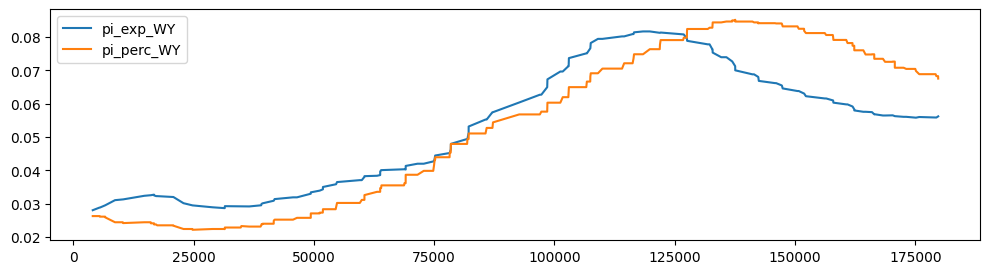

In [78]:
sub = hhp[['pi_exp_WY', 'pi_perc_WY',]].drop_duplicates().dropna().copy()
sub.plot();

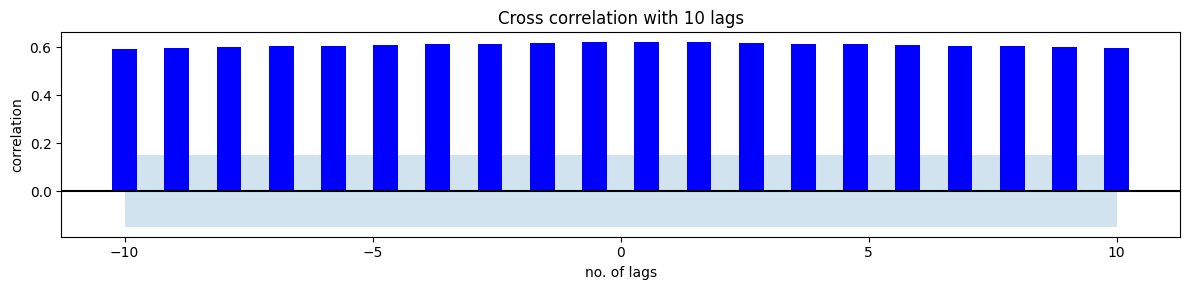

In [79]:
_ = cross_corr(sub.values[:,0], sub.values[:,1], lags=10)

## delta perc - exp and delta pi

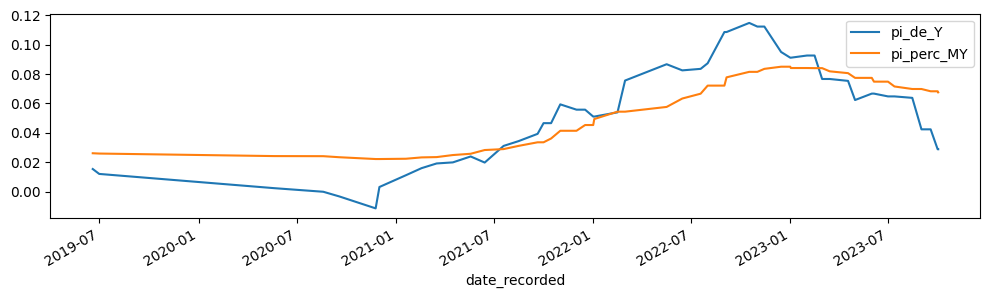

In [53]:
sub = df[['pi_de_Y', 'pi_perc_MY',]].drop_duplicates().dropna().copy()
sub.plot();

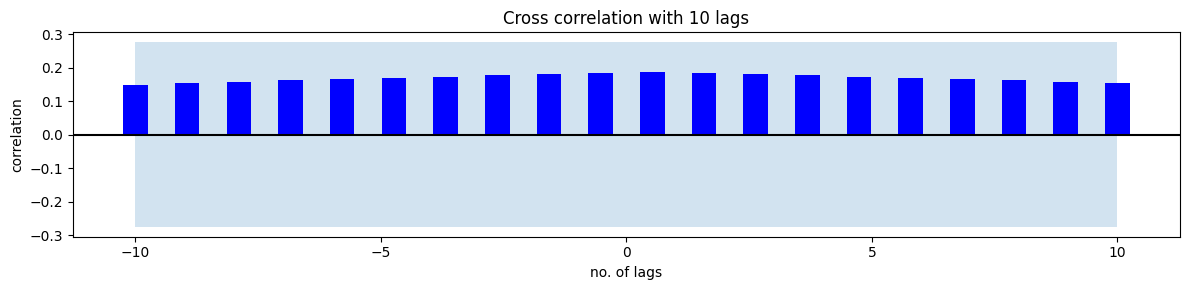

In [54]:
_ = cross_corr(sub.values[:,0], sub.values[:,1], lags=10)

# hhp and pi

In [76]:
sub = pd_join_freq(hhp.set_index('date_recorded'), pi[['pi_de', 'pi_de_Y', 'pi_de_surprise_Y']], 'M', keep_left_index=True)

In [195]:
_ = sub[['pi_perc_WY', 'delta_pe_WY']].drop_duplicates().dropna().values

In [292]:
arr1, arr2 = _[:,0], _[:,1]

In [261]:
from statsmodels.tsa.stattools import ccovf

In [258]:
arr1 = (arr1 - np.mean(arr1) / np.std(arr1) * len(arr1))
arr2 = (arr2 - np.mean(arr2) / np.std(arr2))

In [280]:
arr1, arr2 = np.sin(np.linspace(-10,10,1_000)), np.sin(np.linspace(-9.5,10.5,1_000))

In [290]:
k

69

In [288]:
len(arr1)

1000

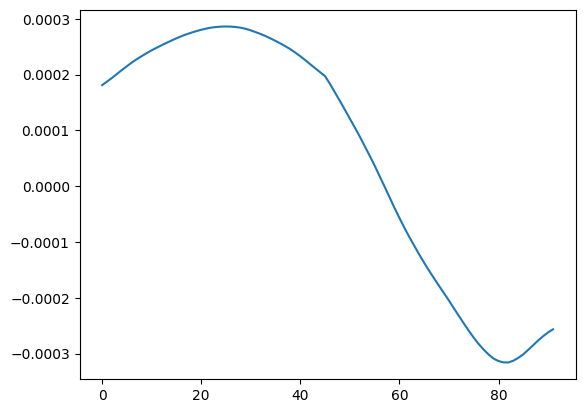

In [294]:
k = int(10 * np.log(len(arr1)/1))
plt.plot(
    # scipy.signal.correlate(arr1, arr2)
    np.correlate(arr1, arr2, 'full')[len(arr1)-k: len(arr1)+k] / (len(arr1))
)
# plt.axhline(y=2/np.sqrt(len(arr1)))
# plt.axhline(y=-2/np.sqrt(len(arr1)))

(array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9,  10]),
 array([0.39943352, 0.39236728, 0.38464753, 0.37658861, 0.36719017,
        0.3572467 , 0.34647852, 0.33527431, 0.32423308, 0.31330558,
        0.30241847, 0.28066491, 0.25728922, 0.23406418, 0.20992948,
        0.18534459, 0.16106944, 0.13611246, 0.1097614 , 0.08344632,
        0.05634014]),
 <matplotlib.lines.Line2D at 0x1cc2d89c810>)

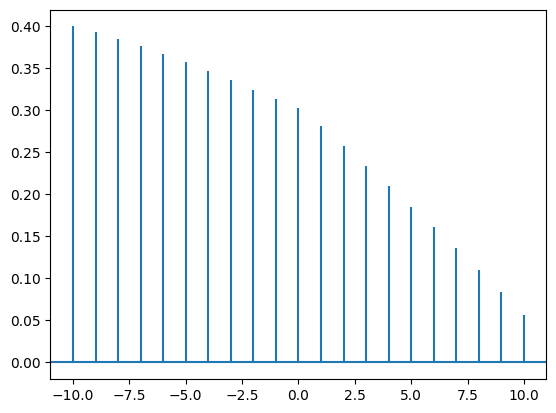

In [271]:
plt.xcorr(arr1, arr2, normed=True, )
# plt.plot(np.correlate(arr1, arr2, 'full')[len(arr1):])

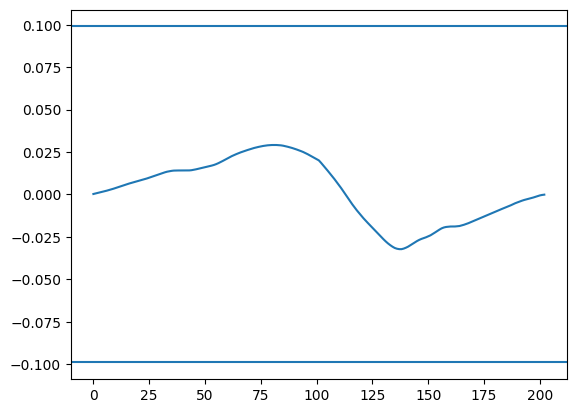

In [262]:
plt.plot(np.correlate(arr1, arr2, 'full'))
plt.axhline(y=+1/np.sqrt(len(arr1)))
plt.axhline(y=-1/np.sqrt(len(arr1)))

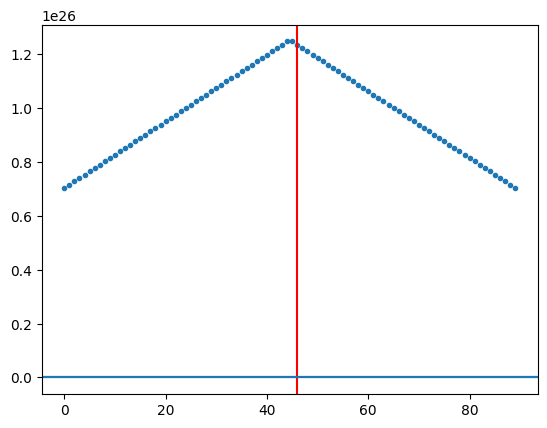

In [221]:
k = int(10*np.log(len(arr1)/1)) # m = 2, m -> number of series
# p = (p - np.mean(p)) / (np.std(p) * len(p))
#     q = (q - np.mean(q)) / (np.std(q))  
# arr1 = (arr1 - np.mean(arr1) / np.std(arr1) * len(arr1))
# arr2 = (arr2 - np.mean(arr2) / np.std(arr2))
corr = np.concatenate(
    [
        [np.correlate(arr1[:-i], arr2[i:]) for i in reversed(range(1,k))],
         # [np.correlate(arr1, arr2)],
        [np.correlate(arr1[i:], arr2[:-i]) for i in range(1,k)]
    ]
)
corr /= (len(arr1)-k)
plt.plot(corr, lw=.1, marker='.')

plt.axvline(k, color='red')
plt.axhline(y=0)
plt.axhline(y=1/np.sqrt(len(arr1)-k))
plt.axhline(y=-1/np.sqrt(len(arr1)-k))
# plt.plot(scipy.signal.correlate(arr1,arr2))

In [211]:
corr[:,0]

array([ 3.29720312e-04,  3.41309242e-04,  3.53375928e-04,  3.66259340e-04,
        3.79200421e-04,  3.91451356e-04,  4.03626007e-04,  4.14383367e-04,
        4.24526250e-04,  4.34179490e-04,  4.43415160e-04,  4.51782753e-04,
        4.59801750e-04,  4.67541553e-04,  4.75203457e-04,  4.82566460e-04,
        4.89349340e-04,  4.95475424e-04,  5.00841553e-04,  5.05844492e-04,
        5.10413091e-04,  5.14227585e-04,  5.17266404e-04,  5.19341062e-04,
        5.20651331e-04,  5.21084057e-04,  5.20607805e-04,  5.19232217e-04,
        5.17048949e-04,  5.13320850e-04,  5.08330790e-04,  5.02468278e-04,
        4.96509925e-04,  4.89537662e-04,  4.81971803e-04,  4.73899191e-04,
        4.65515607e-04,  4.56356682e-04,  4.46795341e-04,  4.35644778e-04,
        4.23847553e-04,  4.11071884e-04,  3.97778900e-04,  3.84679274e-04,
        3.71714574e-04,  3.32988758e-04,  3.05255184e-04,  2.77700348e-04,
        2.49066254e-04,  2.19898051e-04,  1.91097330e-04,  1.61487658e-04,
        1.30224018e-04,  

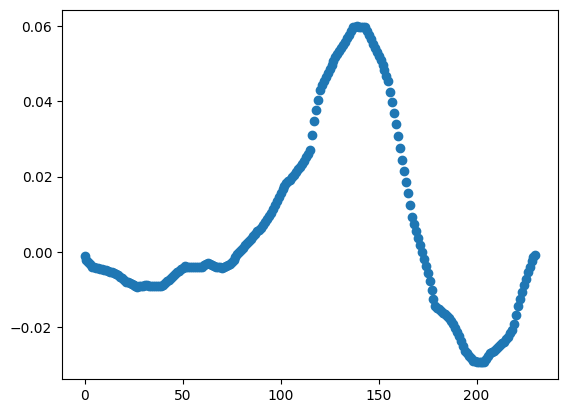

In [55]:
plt.plot(get_cross_corr(_), lw=0, marker='o')

# merge

In [102]:
df = pd_join_dfs(
    [
        pi[['pi_de', 'pi_de_Y', 'pi_de_estimate_Y', 'pi_de_surprise_Y']],
        hhp.set_index('date_recorded')[['pi_perc_MY', 'pi_perc_WY']],
        mir,
    ],
    index_name='date_recorded'
)

In [103]:
df = pd_join_dfs([df, hhp.set_index('date_forecast')[['pi_exp_MY', 'pi_exp_WY']]], index_name='date_recorded')

In [105]:
sub = pd_groupby(df, ['pi_de_Y', 'pi_exp_MY', 'pi_perc_MY'], 'M', 'last').dropna()
sub

,pi_de_Y,pi_exp_MY,pi_perc_MY
M,,,
2020-05-01,0.002310,0.026416,0.024154
2021-04-01,0.019859,0.030827,0.024859
2021-05-01,0.023895,0.031272,0.025730
2021-06-01,0.019747,0.032204,0.028276
2021-07-01,0.031078,0.032593,0.028916
2021-08-01,0.034376,0.032689,0.031120
2021-09-01,0.039301,0.031983,0.033542
2021-10-01,0.046582,0.030965,0.036134
2021-11-01,0.059379,0.029467,0.041388


<AxesSubplot: xlabel='M'>

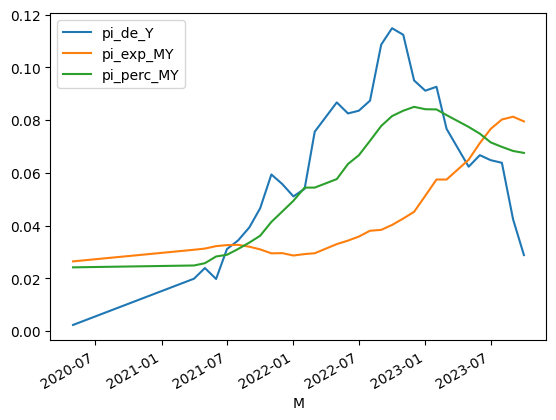

In [106]:
sub.plot()

In [107]:
for i in sub:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")

pi_de_Y ADF p-val: 0.4365980438560606
pi_exp_MY ADF p-val: 0.983474142271522
pi_perc_MY ADF p-val: 0.2736102557915797


In [108]:
jtest = select_coint_rank(sub, 0, 5, method="maxeig", signif=0.05)
print(jtest.summary())
jtest.rank

Johansen cointegration test using maximum eigenvalue test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   1          39.84          21.13
  1   2          17.97          14.26
  2   3         0.8133          3.841
-------------------------------------


2

In [109]:
vecm = VECM(sub, coint_rank=jtest.rank).fit()

C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [110]:
vecm.summary();

In [111]:
sub.columns

Index(['pi_de_Y', 'pi_exp_MY', 'pi_perc_MY'], dtype='object')

In [113]:
vecm.test_granger_causality('pi_exp_MY', 'pi_de_Y' ).summary()

Test statistic,Critical value,p-value,df
0.5448,3.168,0.583,"(2, 54)"


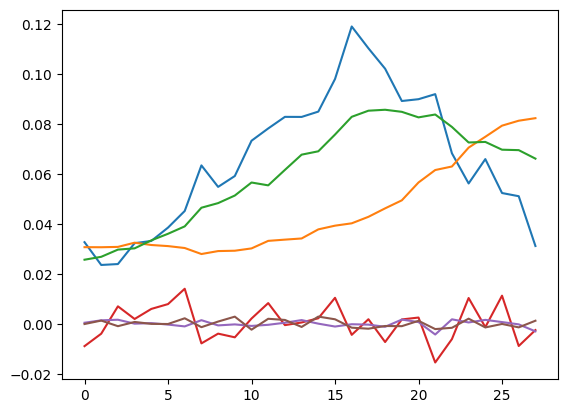

In [114]:
plt.plot(vecm.fittedvalues)
plt.plot(vecm.resid)

In [33]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import normaltest, ttest_1samp

In [35]:
for i in range(vecm.resid.shape[1]):
    print("\n", i, acorr_ljungbox(vecm.resid[:, i], boxpierce=True, model_df=1))


 0     lb_stat  lb_pvalue   bp_stat  bp_pvalue
1  1.472130        NaN  1.361720        NaN
2  2.318970   0.127805  2.123876   0.145019
3  5.897578   0.052403  5.255159   0.072253
4  6.116013   0.106100  5.440828   0.142221
5  6.755200   0.149404  5.968157   0.201539
6  7.002857   0.220428  6.166283   0.290374
7  7.926116   0.243566  6.881808   0.331916

 1     lb_stat  lb_pvalue   bp_stat  bp_pvalue
1  1.245613        NaN  1.152192        NaN
2  1.812204   0.178244  1.662124   0.197317
3  3.749220   0.153415  3.357013   0.186653
4  5.388630   0.145454  4.750511   0.191004
5  5.428849   0.246055  4.783692   0.310221
6  8.463596   0.132469  7.211489   0.205381
7  9.101995   0.167923  7.706249   0.260424


# Exp 3

Aggregate effect of news on inflation expectation